In [1]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

Using synthetic dataset

In [2]:
import numpy as np

# Parameters
num_matrices = 5000
matrix_size = (4, 4)

# Generate matrices filled with ones
matrices = np.ones((num_matrices, *matrix_size))

# Create a sine wave function for scaling
# Let's scale the matrices by the sine of indices (0, 1, ..., num_matrices-1)
scaling_factors = np.abs(np.sin(np.linspace(0, 5 * np.pi, num_matrices)))

# Scale each matrix by its corresponding sine value
scaled_matrices = matrices * scaling_factors[:, np.newaxis, np.newaxis]

# Check the shape of the resulting array
print(scaled_matrices.shape)  # Should be (5000, 4, 4)


(5000, 4, 4)


In [3]:
# Create a toy topology, all link capacities have a value of 5
G = fully_connected_network(num_nodes=4, capacity=1)

# Get ground truth u values 
mlu_ground_truth = np.zeros((num_matrices, ))

for i in range(num_matrices): 
    D = scaled_matrices[i, :, :]
    np.fill_diagonal(D, 0)
    mlu_ground_truth[i] = MinMaxLinkUtil(G, D)

    
# Split ground truth u values into training and testing labels
mlu_train_labels, mlu_test_labels = train_test_split(mlu_ground_truth.reshape(-1, 1), 0.8)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19


Text(0, 0.5, 'MLU')

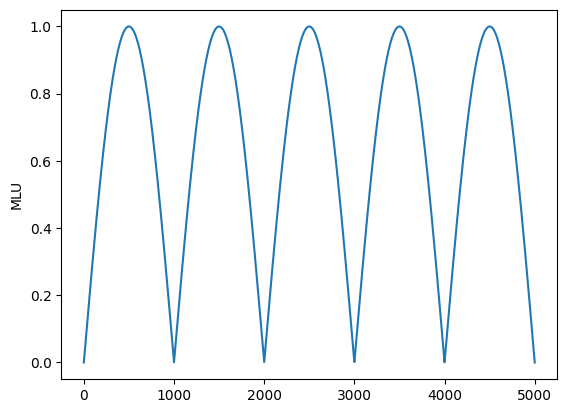

In [4]:
plt.plot(mlu_ground_truth)
plt.ylabel('MLU')

Train NN to Learn MLU

In [5]:
# Train-Test Split 
train_data, test_data = train_test_split(scaled_matrices.reshape(-1, 16), 0.8)

In [7]:
input_size = train_data.shape[1] # Number of features in input
output_size = 1  # Number of output classes 
learn_rate = 0.001 
epochs = 100
batch_size = 32
shuffle = False #don't want to lose the time dependency
num_workers = 4  # Number of subprocesses to use for data loading

In [8]:
# Create a dataset with mlu_train_labels as the labels for each corresponding traffic matrix 

train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(train_data),
                                                 torch.Tensor(mlu_train_labels.reshape(-1)))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=shuffle)


In [9]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(16, 12)
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, 1)  # Output layer for scalar value

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function for output
        return x


In [10]:
def train(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    track_losses = np.zeros(epochs)
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs.squeeze(), labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

        track_losses[epoch] = loss.item()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():10.4e}')
    
    return track_losses

In [11]:
nn_approx = MLP()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(nn_approx.parameters(), lr=0.001)

# Train the model
track_losses = train(nn_approx, train_loader, criterion, optimizer)

Epoch [10/100], Loss: 3.4433e-03
Epoch [20/100], Loss: 1.3592e-03
Epoch [30/100], Loss: 4.3658e-04
Epoch [40/100], Loss: 3.2292e-04
Epoch [50/100], Loss: 2.8892e-04
Epoch [60/100], Loss: 2.6148e-04
Epoch [70/100], Loss: 2.3542e-04
Epoch [80/100], Loss: 2.1111e-04
Epoch [90/100], Loss: 1.8811e-04
Epoch [100/100], Loss: 6.0570e-05


Text(0.5, 1.0, 'Synthetic Dataset: \n Training Loss vs. Epochs: 2 Layer FFNN (16-12-8-1) \n w/ Sigmoid & ReLU Activation Functions')

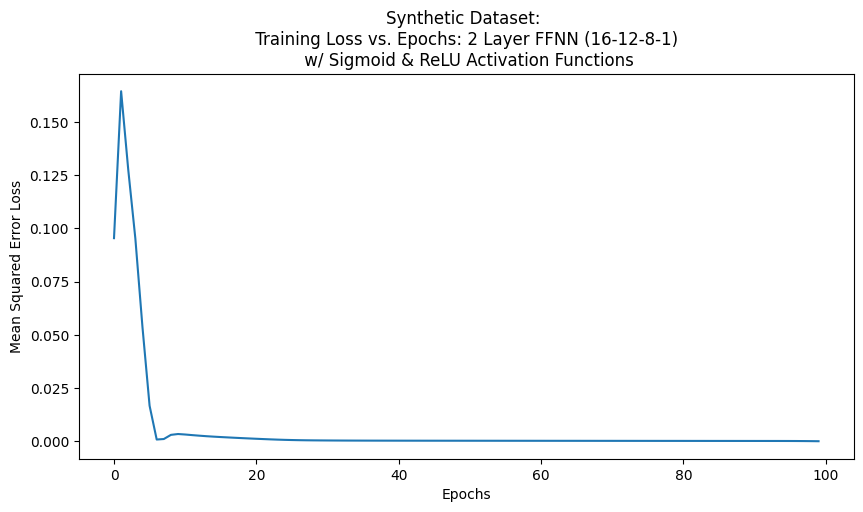

In [14]:
# Plot training loss 
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(range(epochs), track_losses)

# Label Figure
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error Loss')
ax.set_title('Synthetic Dataset: \n Training Loss vs. Epochs: 2 Layer FFNN (16-12-8-1) \n w/ Sigmoid & ReLU Activation Functions')

In [18]:
def evaluate_model(model, test_loader, criterion, mlu_test_labels):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    model_outputs = torch.zeros((mlu_test_labels.shape))

    start_idx = 0
    end_idx = start_idx + 32
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):    
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            model_outputs[start_idx:end_idx, :] = outputs
            start_idx += (outputs.shape[0])
            end_idx = start_idx + outputs.shape[0]

    average_loss = total_loss / len(test_loader)
    print(f'Average Test Loss: {average_loss:10.4e}')

    return model_outputs

In [16]:
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(test_data),
                                                 torch.Tensor(mlu_test_labels))


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=shuffle)


In [19]:
# Evaluate the model
model_outputs = evaluate_model(nn_approx, test_loader, criterion, mlu_test_labels)

Average Test Loss: 6.3789e-04


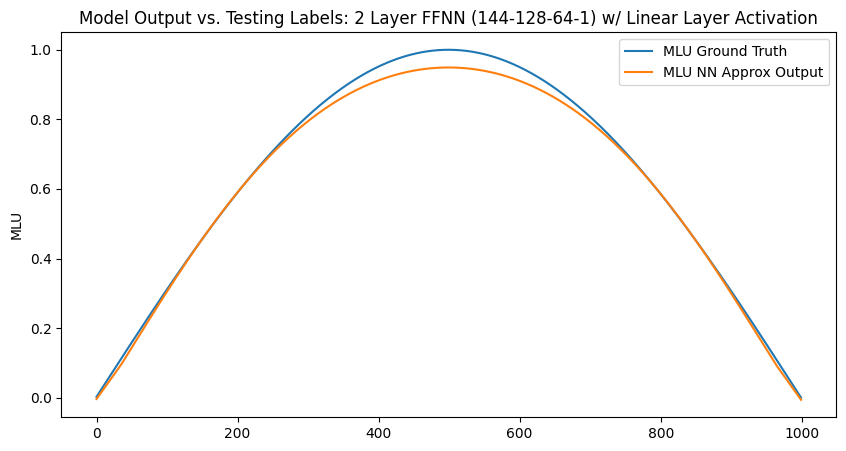

In [20]:
# plot test labels vs. outputs 
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(mlu_test_labels, label = 'MLU Ground Truth')
ax.plot(model_outputs, label = 'MLU NN Approx Output')

# Label Figure
ax.set_ylabel('MLU')
ax.set_title('Model Output vs. Testing Labels: 2 Layer FFNN (144-128-64-1) w/ Linear Layer Activation')
ax.legend()

Train a predictor on the synthetic dataset

In [21]:
# Window the dataset
trainX, trainY = create_dataset(train_data, 10)
testX, testY = create_dataset(test_data, 10)

In [22]:
# Specify model parameters 
input_size = trainX.shape[2] # Number of features in input
hidden_size = 200  # Number of features in hidden state
output_size = 16  # Number of output classes 
learn_rate = 0.001 
epochs = 100
num_layers = 1
batch_size = 32
shuffle = False #don't want to lose the time dependency
num_workers = 4  # Number of subprocesses to use for data loading

In [23]:
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(trainX),
                                                 torch.Tensor(trainY), 
                                                 torch.FloatTensor(mlu_train_labels[10:, :]))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=shuffle)

test_dataset  = torch.utils.data.TensorDataset(torch.FloatTensor(testX),
                                                 torch.Tensor(testY),
                                                 torch.FloatTensor(mlu_test_labels[10:, :]))


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             num_workers=num_workers,
                                             shuffle=shuffle)

In [24]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, _ = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])  # return the last value
        out = self.sigmoid(out)
        return out

In [27]:
import time

# Define training function

def train_predictor(model, train_loader, epochs, criterion, optimizer, mlu_train_labels, model_approx):
    ''' Train ML Model''' 

    track_losses = np.zeros(epochs)
    u = torch.FloatTensor(mlu_train_labels[10:])

    for epoch in range(epochs): 
        start_idx = 0 
        end_idx = start_idx+32
        for idx, (inputs, _, _) in enumerate(train_loader): 
            
            # Pass data to LSTM
            optimizer.zero_grad()
            outputs = model(inputs) # Get Outputs

            # Pass outputs to NN aproximator 
            u_prime = model_approx(outputs)
            
            # Compute the loss between u_prime and u
            target_u = u[start_idx:end_idx]
            loss = criterion(u_prime.squeeze(), target_u) #mse loss
            
            start_idx += u_prime.shape[0] 
            end_idx = start_idx + u_prime.shape[0]

            # Compute the gradient and update the network parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        training_loss = loss.item()
        track_losses[epoch] = training_loss 

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():10.4e}')

    return track_losses

In [28]:
# Call model
predictor = RNN(input_size, hidden_size, num_layers)

# Create optimizer 
optimizer = optim.Adam(predictor.parameters(), lr=learn_rate)

# Create loss function
criterion = nn.MSELoss()

loss = train_predictor(predictor, train_loader, epochs, criterion, optimizer, mlu_train_labels.reshape(-1), nn_approx)


Epoch [10/100], Loss: 8.7213e-03
Epoch [20/100], Loss: 3.3948e-03
Epoch [30/100], Loss: 2.2299e-03
Epoch [40/100], Loss: 1.8391e-03
Epoch [50/100], Loss: 4.6046e-04
Epoch [60/100], Loss: 5.7157e-04
Epoch [70/100], Loss: 5.2183e-04
Epoch [80/100], Loss: 1.1300e-03
Epoch [90/100], Loss: 3.9910e-04
Epoch [100/100], Loss: 5.3272e-04


Text(0.5, 1.0, 'Training Loss vs. Epochs')

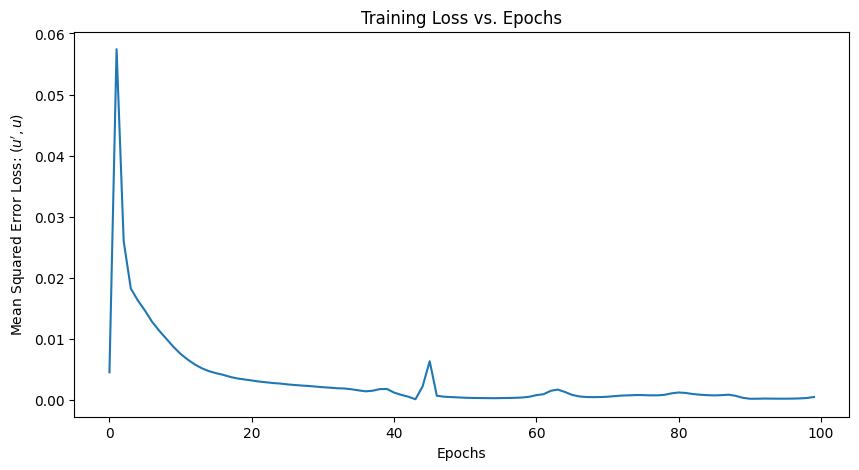

In [29]:
# Plot the training loss 
# Plot training loss 
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(range(epochs), loss)

# Label Figure
ax.set_xlabel('Epochs')
ax.set_ylabel(r'Mean Squared Error Loss: $(u^{\prime}, u)$')
ax.set_title('Training Loss vs. Epochs')

In [30]:
# Evaluate the predictor 
def evaluate_predictor(model, test_loader, criterion, nn_approx):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    model_outputs = np.zeros((testY.shape[0], 1))
    predicted_tms = np.zeros((testY.shape))
    start_idx = 0
    end_idx = start_idx + 32
    with torch.no_grad():
        for idx, (inputs, labels, mlu_gt) in enumerate(test_loader):    
            outputs = model(inputs)
            predicted_tms[start_idx:end_idx, :] = outputs
            u_prime = nn_approx(outputs)

            loss = criterion(u_prime, mlu_gt)
            total_loss += loss.item()
            
            model_outputs[start_idx:end_idx, :] = u_prime
            start_idx += (outputs.shape[0])
            end_idx = start_idx + outputs.shape[0]

    average_loss = total_loss / len(test_loader)
    print(f'Average (Normalized) Test Loss: {average_loss:10.4e}')

    return model_outputs, predicted_tms

In [31]:
model_outputs, predicted_tms = evaluate_predictor(predictor, test_loader, criterion, nn_approx)

Average (Normalized) Test Loss: 1.9677e-04


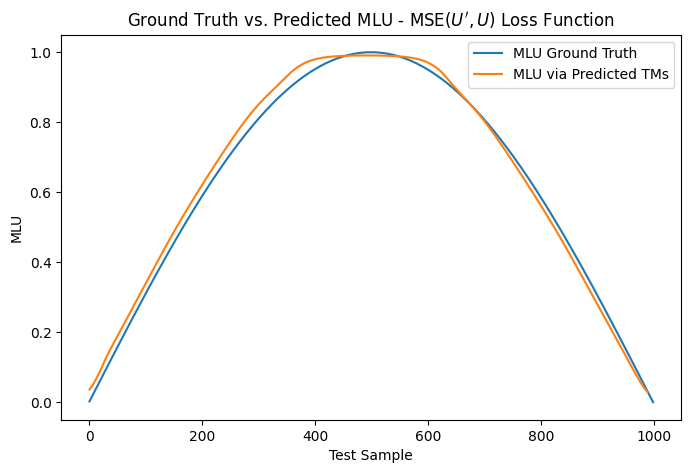

In [32]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(mlu_test_labels, label = 'MLU Ground Truth')
ax.plot(model_outputs, label = 'MLU via Predicted TMs')

ax.set_xlabel('Test Sample')
ax.set_ylabel('MLU')
ax.legend()
_ = ax.set_title(r'Ground Truth vs. Predicted MLU - MSE($U^{\prime}, U$) Loss Function')

1045.6104903372575


/tmp/ipykernel_622228/799604650.py:1: RuntimeWarning: divide by zero encountered in divide
  bias = model_outputs/mlu_test_labels[10:]


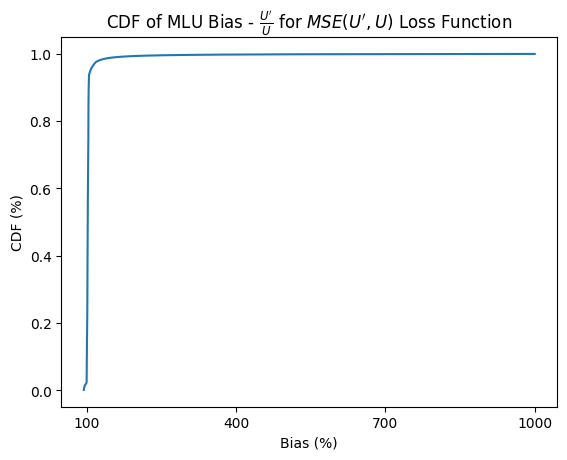

In [38]:
bias = model_outputs/mlu_test_labels[10:]
data_size = len(bias)

data = np.reshape(bias*100, (len(model_outputs),))

data_set = sorted(set(data))
bins = np.append(data_set, data_set[-1] + 1)

# Use the histogram function to bin the data
counts, bin_edges = np.histogram(data, bins=bins, density=False)
counts = counts.astype(float) / data_size

# Find the cdf
cdf = np.cumsum(counts*100)
plt.plot(bin_edges[0:-1], cdf/np.max(cdf))
plt.xlabel('Bias (%)')
plt.ylabel('CDF (%)')
plt.title(r'CDF of MLU Bias - $\frac{U^{\prime}}{U}$ for $MSE(U^{\prime}, U)$ Loss Function')

start, end = plt.xlim()
print(end)
_ = plt.xticks(np.arange(100, end, 300))

Text(440, 50, 'NMSE: 2.007')

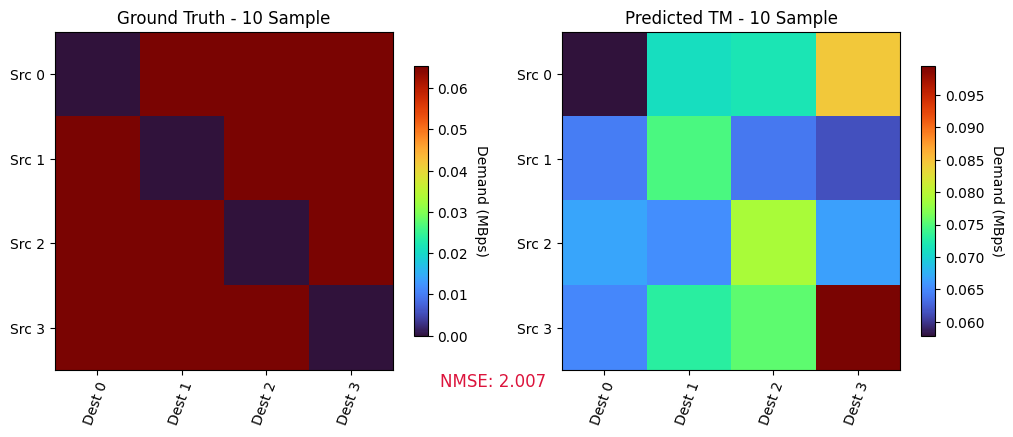

In [39]:
# Visual comparison of model outputs and ground truth
sources = ['Src {}'.format(i) for i in range(0,4)]
destinations = ['Dest {}'.format(i) for i in range(0,4)]

sample_number = 10

# Create a heatmap
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (12,5))
im1 = ax1.imshow(np.reshape(test_data[sample_number+10, :], (4,4)), cmap = 'turbo') #scaled ground truth

# Create colorbar
cbar = ax1.figure.colorbar(im1, ax=ax1, shrink = 0.7)
cbar.ax.set_ylabel('Demand (MBps)', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax1.set_xticks(np.arange(len(destinations)), labels=destinations)
ax1.set_yticks(np.arange(len(sources)), labels=sources)

# Rotate the tick labels and set their alignment.
plt.setp(ax1.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


ax1.set_title("Ground Truth - %d Sample" % sample_number)

im2 = ax2.imshow(np.reshape(predicted_tms[sample_number, :], (4,4)), cmap = 'turbo') #scaled prediction

# Create colorbar
cbar = ax2.figure.colorbar(im2, ax=ax2, shrink = 0.7)
cbar.ax.set_ylabel('Demand (MBps)', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(destinations)), labels=destinations)
ax2.set_yticks(np.arange(len(sources)), labels=sources)

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


ax2.set_title("Predicted TM - %d Sample" % sample_number)

# Compute normalized mean squared error 
actual = test_data[sample_number+10, :]
predicted = predicted_tms[sample_number, :]

mse = sum([(a - p) ** 2 for a, p in zip(actual, predicted)]) / len(actual)
mean_actual = sum(actual) / len(actual)
normalization_factor = sum([(a - mean_actual) ** 2 for a in actual]) / len(actual)
nmse = mse / normalization_factor

plt.annotate('NMSE: %0.3f' % nmse, 
            xy = (440, 50), xycoords='figure pixels', color = 'crimson',
            fontsize = 12)

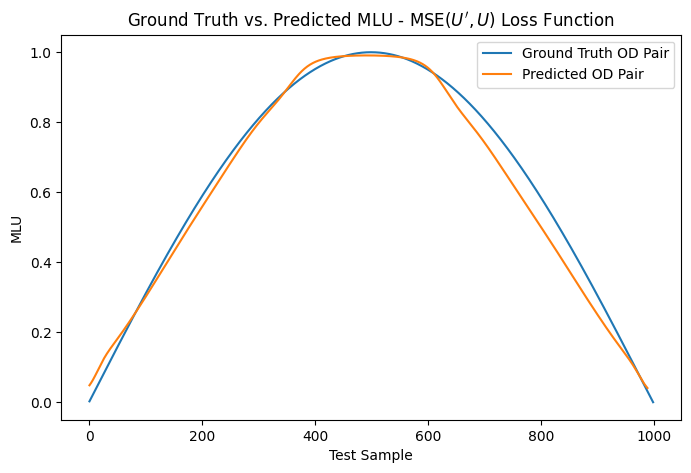

In [49]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_data[:, 14], label = 'Ground Truth OD Pair')
ax.plot(predicted_tms[:, 14], label = 'Predicted OD Pair')

ax.set_xlabel('Test Sample')
ax.set_ylabel('MLU')
ax.legend()
_ = ax.set_title(r'Ground Truth vs. Predicted MLU - MSE($U^{\prime}, U$) Loss Function')